## 1. Import Libraries

In [1]:
pip install twitter-text-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [3]:
import sys
!{sys.executable} -m pip install xgboost

In [4]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('punkt')
nltk.download('words')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from string import punctuation
from nltk.corpus import stopwords
from nltk.corpus import words

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Yufeng\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Yufeng\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yufeng\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from html import unescape
from nltk.stem import PorterStemmer
from ttp import ttp

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier

## 2. Data Cleaning

In [9]:
# import data (shuold be changed on the cloud)
stmt = pd.read_csv('D:\\MIE1624\\Assignment_2\\Sentiment.csv')
c_elect = pd.read_csv('D:\\MIE1624\\Assignment_2\\Canadian_elections_2019.csv')

- I found there are lots of single letters like 'b' and 'n' in the initial process. 'b' is at the beginning of each tweet, and 'n' is remained parts of strings like '\\n'. And 'X' is the remain part of Emoji. I added them in to stopwords. Delete several single letters in each tweet has no effects on the analysis. 

- For html characters, I think it is better to unescape them than convert them to ASCII number, because that would be confused with other numbers, and otherwise html characters seem not affect the sentiment analysis, and they will be removed eventually.

In [10]:
# define stopwords list
stopword_list = stopwords.words('english') +list(punctuation) +['b', 'n', 'X', 'x']

# funtion for data cleaning
def data_cleaning(row, stopword_list):

    row = row.lower()
    row = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', r'', row) # uniform URL
    row = re.sub('@[^\s]+', r'', row) # remove username
    row = unescape(row)
    tokenizer = RegexpTokenizer(r'\w+')
    row = tokenizer.tokenize(row)
    row = [word for word in row if re.match(r'[A-Za-z]+', word)]
    row = [word for word in row if word not in stopword_list]
    #pstm = PorterStemmer()
    #row = [pstm.stem(word) for word in row] # stem the tweet
    return row 

- Clean the Canadian Election Data (will be called _election data_ in the following).

In [11]:
c_elect_cleaned = c_elect.copy()
c_elect_cleaned['text'] = c_elect['text'].apply(data_cleaning, args=(stopword_list,))

- Clean _sentiment.csv_ data. There are some texts that are nan value. Thus, they should be replaced by 'notext' for further processing according to the assignment requirement.

In [12]:
stmt_cleaned = stmt.copy()

In [13]:
# keep empty tweets
for twt in stmt_cleaned['text']:
    if isinstance(twt, float):
        stmt_cleaned = stmt_cleaned.replace(twt, 'notext')

In [14]:
stmt_cleaned['text'] = stmt_cleaned['text'].apply(data_cleaning, args=(stopword_list,))

## 3. Exploratory Analysis

### 3.1 Party determination

- The simple method for party determination mainly considers the _hashtags_ and _key words_ in the cleaned data. 

- The following part is the collection the set of hashtags

In [15]:
# use tweeter API to recognize hashtags
p = ttp.Parser()

In [16]:
tags = []
for tweet in c_elect['text']:
    results = p.parse(tweet)
    tags = tags+results.tags
tags = pd.DataFrame(tags)
tags.columns = ['tags']
tags = pd.DataFrame(tags['tags'].value_counts())

- Process hashtags:

    - Drop all hastags that appear less than twice. Because if the tag appear less than twice, then at most 2 tweets use that tag, thus analyze that tag is equivalent to analyze only one or two tweets, which will be too specific to be a deterministic procedure.

    - Drop hastags that are not politically biased, like 'elxn43' that related to all election issues.

In [17]:
tags = tags[tags['tags']>2]

In [18]:
# drop tags that contain upper and lower case of elxn43
tags = tags[~tags.index.str.match(r'([Ee][Ll])|43')]
# drop tags that contain upper or lower case of cdn
tags = tags[~tags.index.str.match(r'[cC][Dd][nN]')]
# drop tags that contain poli
tags = tags[~tags.index.str.match(r'^\S+[Pp][Po][Ll]i$')]
# drop tags that contain can
tags = tags[~tags.index.str.match(r'[Cc]an\S+')]

tags = tags[~tags.index.str.match(r'[Cc]limate')]

- The polical bias of the hashtags are selected manually from the remain hashtags. Some of the hashtags are combinations of the hashtags below, like '#JustinTrudeau'. Then use the elements below can recognize these combined tags.

In [19]:
# hashtags or keywords list for every political party
liberal = ['forward', 'trudeau', 'liberal','lpc', 'andrew','lavalin', 'justin','josephine', 'tsang']
conservative = ['kinsella','gate', 'conservative', 'scheer','cpc','andy']
ndp = ['uprisingh', 'jagmeet', 'singh', 'ndp','vangran', 'democratic']
others = ['ppc','greenparty']

In [20]:
type_list = []

for twt in c_elect_cleaned['text']:
    no_lib = 0
    no_con = 0
    no_ndp = 0
    no_others = 0
    
    for word in twt:
        if any(word in s for s in liberal):
            no_lib += 1
        elif any(word in s for s in conservative):
            no_con += 1
        elif any(word in s for s in ndp):
            no_ndp += 1
        elif any(word in s for s in others):
            no_others += 1
        else:
            pass
    if max(no_lib, no_con, no_ndp, no_others):
        no_dict = {'Liberal':no_lib, 'Conservative':no_con, 'NDP': no_ndp, 'Others':no_others}
        twt_type = max(no_dict, key=no_dict.get)
    else:
        twt_type='None'
        
    type_list.append(twt_type)

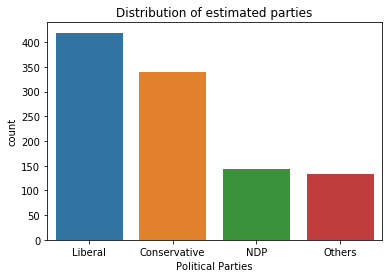

In [131]:
party_dist = np.array([party for party in type_list if party != 'None'])
sns.countplot(party_dist, order=['Liberal', 'Conservative', 'NDP', 'Others'])
plt.xlabel('Political Parties')
plt.title('Distribution of estimated parties')
plt.show()

- In addition to the assignment requirements, I add 'Others' to represent other parties, like PPC or Green Party.
- As we know Liberal and Conservative are parties that supported by high populations, and Liberal won the election. So this distribution is reasonable from this perspective.
- About Half of the data samples are labeled by parties, the other half are labeled by none since no key words found it that tweet. The figure only shows the labeled samples.

### 3.2 Tweets Visualization

- Plot the distribution of the length of the tweets in each datasets, also consider the labels.

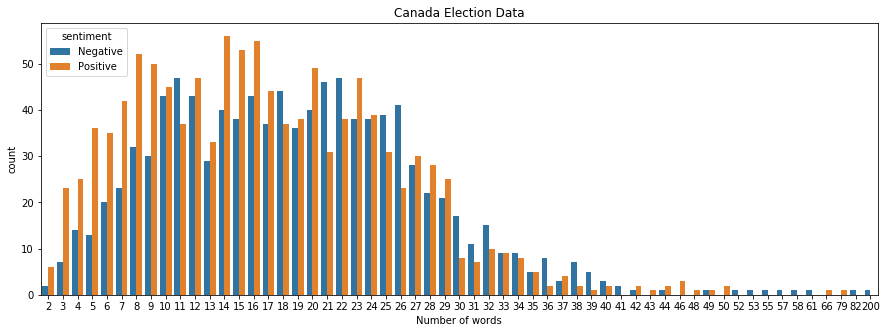

In [134]:
# for election dataset
# the length of each tweet
length_ele = [len(twt) for twt in c_elect_cleaned['text']]

plt.subplots(figsize=(15,5))
sns.countplot(length_ele, hue=c_elect_cleaned['sentiment'])
plt.xlabel('Number of words')
plt.title('Canada Election Data')
plt.show()

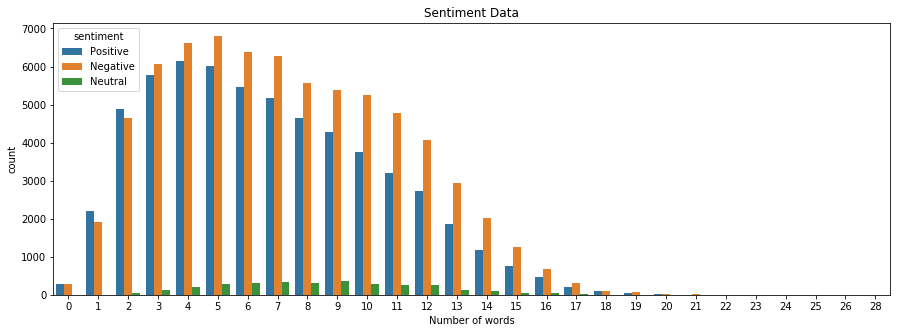

In [135]:
# for sentiment dataset

length_sen = [len(twt) for twt in stmt_cleaned['text']]

plt.subplots(figsize=(15,5))
sns.countplot(length_sen, hue=stmt_cleaned['sentiment'])
plt.xlabel('Number of words')
plt.title('Sentiment Data')
plt.show()

- __Analysis:__
    1. For the overall trends of both datasets: 
        - The positive samples and the nagative samples are relatively balanced. This is suitable for classification. The _sentiment.csv_ data has also 'Neutral' label, which will be remove during binary classification.
        - In each of the data set, data with each label share the same trends. This means that the length of tweet can not be a feature to classify the labels.
    2. Difference between datasets:
        - One the the obvious differenc is the number of data samples. The samples are much more aboundant in _sentiment.csv_ data. 
        - Another differece is that the average length of _sentiment.csv_ data is about 5 words, whereas average 14 words per tweet in election data. In this way, text in election data is more complex.

## 4. Model preparation

### 4.1 Binary Classification

- __Data Vectorization__: both WF and TF-IDF are considered as features and vectorized.

In [24]:
# remove Neutral samples
stmt_binary = stmt_cleaned[~(stmt_cleaned['sentiment'] == 'Neutral')]

In [25]:
# convert sentiment labels into numbers
dict_label = {'Positive':1, 'Negative':0}
y_stmt = stmt_binary.loc[:, 'sentiment'].map(dict_label)
y_elexn = c_elect_cleaned.loc[:, 'sentiment'].map(dict_label)

In [26]:
# build the totoal corpus for
stmt_corpus = []
for twt in stmt_binary['text']:
    twt_comb = ' '.join(twt)
    stmt_corpus.append(twt_comb)
    
elexn_corpus = []
for twt in c_elect_cleaned['text']:
    twt_comb = ' '.join(twt)
    elexn_corpus.append(twt_comb)
    
tot_corpus = stmt_corpus + elexn_corpus

In [27]:
# word frequency
wf_vectorizer = CountVectorizer(max_features=5000).fit(tot_corpus)
X_wf = wf_vectorizer.transform(stmt_corpus)
X_elexn_wf = wf_vectorizer.transform(elexn_corpus)

In [28]:
# TF-IDF
tf_vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None, max_features=5000).fit(tot_corpus)
X_tfidf = tf_vectorizer.transform(stmt_corpus)
X_elexn_tfidf = tf_vectorizer.transform(elexn_corpus)

- __Split the data:__
    - Split the sentiment data into train and test data.
    - The whole election data will be the test data.

In [29]:
# split sentiment data
X_train_wf, X_test_wf, y_train_wf, y_test_wf = train_test_split(X_wf, y_stmt, train_size=0.7, 
                                                                shuffle=True, random_state=2)

X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tfidf, y_stmt, train_size=0.7, 
                                                                shuffle=True, random_state=2)

- __Consideration of normalizing the data:__
    - Generally, if there are distance-based classifiers, it is necessary to standardize the data. 
    - However, the data transformed to TF-IDF has already been normalized in the function. Data transformed to Word Frequency is not normalized, but each feature represents to the frequency of words, which are comparable to each other. So I tested data normalized and not normalized, the running results reveals that WF data without normalization converges faster and with higher test scores, so WF data will not be normalized in this report.

- __Model preparation for Binary Classification__
    - The selection of __score__ or __performance metric__. In this classification, both labels are equal important, thus only consider Recall or Precision is not suitable. Although confusion matrix is comprehensive, but it is not intuitive to select models by visualization. Thus, the _roc_auc_score_ is selected for it represents the area under the ROC curve. It is both comprehensive and quantitative.

In [31]:
def bi_classifier(estimator, param_dict, X_train, y_train, X_test, y_test, X_election, y_election):
    # hyperparameter tuning
    classifier = GridSearchCV(estimator, param_grid=param_dict, 
                              scoring=make_scorer(roc_auc_score), cv=5)
    classifier.fit(X_train, y_train)
    
    # performance of the best model on the test data
    y_pred = classifier.predict(X_test) 
    test_score = roc_auc_score(y_test, y_pred)
    
    # performance of the best model on election data
    y_pred_election = classifier.predict(X_election)
    test_score_election = roc_auc_score(y_election, y_pred_election)
    
    print('The best hyperparameters are', classifier.best_params_)
    print('The highest ROC area for semetic test data is %f.' % test_score)
    print('The ROC area for election data is %f.' % test_score_election)
      
    return test_score, test_score_election, y_pred_election

In [46]:
# classifiers and parameter grids for word frequency features
LR_WF = [LogisticRegression(penalty='l2', solver='saga', n_jobs=-1),
{'C': [0.1, 0.175, 0.2, 0.225, 0.25, 0.3]}]

KNN_WF = [KNeighborsClassifier(n_jobs=-1), {'n_neighbors': [4,5,6,7]}]

NB_WF = [MultinomialNB(),
{'alpha': [2, 5, 10, 20, 30, 50]}]

SVM_WF = [SGDClassifier(n_jobs=-1, random_state=2),
{'penalty': ['l1', 'l2']}]

DT_WF = [DecisionTreeClassifier(),
{'criterion': ['gini', 'entropy'], 'max_depth': [50, 100, 200, 500]}]

RF_WF = [RandomForestClassifier(n_jobs=-1),
{'n_estimators': [50, 100], 'criterion': ['gini', 'entropy'], 'max_depth': [50, 100, 150, 200, 250]}]

XGB_WF = [xgb.XGBClassifier(objective='binary:logistic', n_jobs=-1, max_depth=200),
{'n_estimators': [100, 150, 200]}]

In [70]:
# classifiers and parameter grids for TF-IDF
LR_TF = [LogisticRegression(penalty='l2', solver='saga', n_jobs=-1),
{'C': [0.0005, 0.001, 0.005, 0.01, 0.05]}]

KNN_TF = [KNeighborsClassifier(n_jobs=-1), {'n_neighbors': [3,4,5,6]}]

NB_TF = [MultinomialNB(),
{'alpha': [100, 105, 110, 115, 120, 125, 130, 135, 140]}]

SVM_TF = [SGDClassifier(n_jobs=-1, random_state=2),
{'penalty': ['l1', 'l2']}]

DT_TF = [DecisionTreeClassifier(),
{'criterion': ['gini', 'entropy'], 'max_depth': [200, 500, 800, 1000]}]

RF_TF = [RandomForestClassifier(n_jobs=-1),
{'n_estimators': [50, 100], 'criterion': ['gini', 'entropy'], 'max_depth': [200, 250, 350, 500]}]

XGB_TF = [xgb.XGBClassifier(objective='binary:logistic', n_jobs=-1, max_depth=200),
{'n_estimators': [10, 20, 30, 50, 80]}]

### 4.2 Multi-classification

- __Data cleaning__: select only the sample with Negative label.

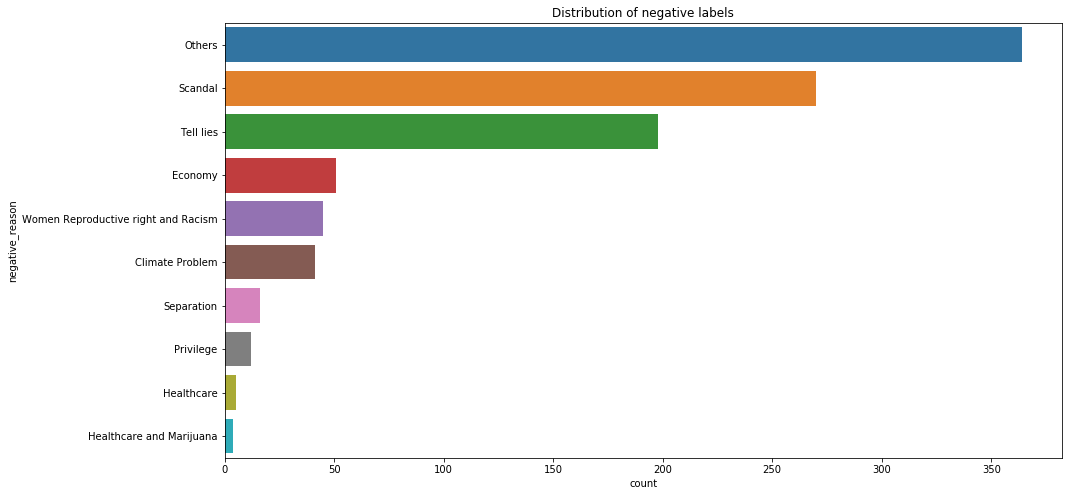

In [38]:
# extract the needed data
c_elect_negative = c_elect_cleaned[c_elect_cleaned['sentiment'] == 'Negative']

# visualize the distribution of negative reasons
plt.subplots(figsize=(15,8))
sns.countplot(y=c_elect_negative['negative_reason'], orient="v", 
              order=c_elect_negative['negative_reason'].value_counts().index)
plt.title('Distribution of negative labels')
plt.show()

- __Analysis__
    - The labels are seriously imbalanced.
    - Healthcare and Healthcare and Marijuana are similar, and can be merged together

In [39]:
# merge labels
c_elect_negative = c_elect_negative.replace('Healthcare and Marijuana', 'Healthcare')

- Ecode the label

In [40]:
encoder = LabelEncoder()
y_label = encoder.fit_transform(c_elect_negative['negative_reason'])

- Data vectorization

In [41]:
# build courpus
elexn_nega_corpus = []
for twt in c_elect_negative['text']:
    twt_comb = ' '.join(twt)
    elexn_nega_corpus.append(twt_comb)
    
# word frequency
wf_nega_vectorizer = CountVectorizer()
X_nega_wf = wf_vectorizer.fit_transform(elexn_nega_corpus)
# TF-IDF
tf_nega_vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None)
X_nega_tfidf = tf_vectorizer.fit_transform(elexn_nega_corpus)

- Split the data

In [42]:
X_train_Nwf, X_test_Nwf, y_train_Nwf, y_test_Nwf = train_test_split(X_nega_wf, y_label, train_size=0.7, 
                                                                shuffle=True, random_state=2)

X_train_Ntf, X_test_Ntf, y_train_Ntf, y_test_Ntf = train_test_split(X_nega_tfidf, y_label, train_size=0.7, 
                                                                shuffle=True, random_state=2)

- Define multiclass classifier
    - __Selection for performance metric:__ In this classification, the balanced accuracy score has been selected, which represents the average precision for each class. It is more comprehensive than normal accuracy.

In [43]:
def multi_classifier(estimator, param_dict, X_train, y_train, X_test, y_test):
    # hyperparameter tuning
    classifier = GridSearchCV(estimator, param_grid=param_dict, 
                              scoring=make_scorer(balanced_accuracy_score), cv=5)
    classifier.fit(X_train, y_train)
    
    # performance of the best model on the test data
    y_pred = classifier.predict(X_test) 
    test_score = balanced_accuracy_score(y_test, y_pred)
    
       
    print('The best hyperparameters are', classifier.best_params_)
    print('The highest balanced accuracy for the test data is %f.' % test_score)
          
    return test_score, y_pred

In [120]:
# classifiers and parameter grids
NB_nega = [MultinomialNB(),
{'alpha': [3, 3.5, 4, 4.5, 5, 5.5]}]

LR_nega = [LogisticRegression(penalty='l2', solver='saga', n_jobs=-1, max_iter=1000),
          {'C':[45, 50, 55, 60, 65, 70]}]

SVM_nega = [SGDClassifier(n_jobs=-1, random_state=2),
{'penalty': ['l1', 'l2']}]

## 5. Model Implementation

### 5.1 Binary Classification

#### 5.1.1 With Word Frequency as Features

- Logistic Regression

In [47]:
lr_ts_wf, lr_tsEle_wf, lr_yPredEle_wf = bi_classifier(LR_WF[0], LR_WF[1], 
                                                      X_train_wf, y_train_wf, 
                                                      X_test_wf, y_test_wf,
                                                     X_elexn_wf, y_elexn)

The best hyperparameters are {'C': 0.225}
The highest ROC area for semetic test data is 0.759010.
The ROC area for election data is 0.614784.


- KNN

In [48]:
knn_ts_wf, knn_tsEle_wf, knn_yPredEle_wf = bi_classifier(KNN_WF[0], KNN_WF[1], 
                                                      X_train_wf, y_train_wf, 
                                                      X_test_wf, y_test_wf,
                                                     X_elexn_wf, y_elexn)

The best hyperparameters are {'n_neighbors': 7}
The highest ROC area for semetic test data is 0.676683.
The ROC area for election data is 0.536739.


- Naive Bayes

In [64]:
nb_ts_wf, nb_tsEle_wf, nb_yPredEle_wf = bi_classifier(NB_WF[0], NB_WF[1], 
                                                      X_train_wf, y_train_wf, 
                                                      X_test_wf, y_test_wf,
                                                     X_elexn_wf, y_elexn)

The best hyperparameters are {'alpha': 5}
The highest ROC area for semetic test data is 0.744500.
The ROC area for election data is 0.592780.


- SVM

In [50]:
svm_ts_wf, svm_tsEle_wf, svm_yPredEle_wf = bi_classifier(SVM_WF[0], SVM_WF[1], 
                                                      X_train_wf, y_train_wf, 
                                                      X_test_wf, y_test_wf,
                                                     X_elexn_wf, y_elexn)

The best hyperparameters are {'penalty': 'l2'}
The highest ROC area for semetic test data is 0.760052.
The ROC area for election data is 0.609934.


- Decision Tree

In [51]:
dt_ts_wf, dt_tsEle_wf, dt_yPredEle_wf = bi_classifier(DT_WF[0], DT_WF[1], 
                                                      X_train_wf, y_train_wf, 
                                                      X_test_wf, y_test_wf,
                                                     X_elexn_wf, y_elexn)

The best hyperparameters are {'criterion': 'entropy', 'max_depth': 500}
The highest ROC area for semetic test data is 0.700913.
The ROC area for election data is 0.552407.


- Random Forest

In [52]:
rf_ts_wf, rf_tsEle_wf, rf_yPredEle_wf = bi_classifier(RF_WF[0], RF_WF[1], 
                                                      X_train_wf, y_train_wf, 
                                                      X_test_wf, y_test_wf,
                                                     X_elexn_wf, y_elexn)

The best hyperparameters are {'criterion': 'entropy', 'max_depth': 250, 'n_estimators': 100}
The highest ROC area for semetic test data is 0.744076.
The ROC area for election data is 0.572481.


- XGBoost

In [53]:
xgb_ts_wf, xgb_tsEle_wf, xgb_yPredEle_wf = bi_classifier(XGB_WF[0], XGB_WF[1], 
                                                      X_train_wf, y_train_wf, 
                                                      X_test_wf, y_test_wf,
                                                     X_elexn_wf, y_elexn)

The best hyperparameters are {'n_estimators': 100}
The highest ROC area for semetic test data is 0.754211.
The ROC area for election data is 0.615278.


#### 5.1.2 With TF-IDF as Features

- Logistic regression

In [62]:
lr_ts_tf, lr_tsEle_tf, lr_yPredEle_tf = bi_classifier(LR_TF[0], LR_TF[1], 
                                                       X_train_tf, y_train_tf, 
                                                      X_test_tf, y_test_tf,
                                                     X_elexn_tfidf, y_elexn)

The best hyperparameters are {'C': 0.005}
The highest ROC area for semetic test data is 0.758909.
The ROC area for election data is 0.621973.


- KNN

In [55]:
knn_ts_tf, knn_tsEle_tf, knn_yPredEle_tf = bi_classifier(KNN_TF[0], KNN_TF[1], 
                                                      X_train_tf, y_train_tf, 
                                                      X_test_tf, y_test_tf,
                                                     X_elexn_tfidf, y_elexn)

The best hyperparameters are {'n_neighbors': 5}
The highest ROC area for semetic test data is 0.679651.
The ROC area for election data is 0.571867.


- Naive Bayes

In [69]:
nb_ts_tf, nb_tsEle_tf, nb_yPredEle_tf = bi_classifier(NB_TF[0], NB_TF[1], 
                                                      X_train_tf, y_train_tf, 
                                                      X_test_tf, y_test_tf,
                                                     X_elexn_tfidf, y_elexn)

The best hyperparameters are {'alpha': 120}
The highest ROC area for semetic test data is 0.744598.
The ROC area for election data is 0.591142.


- SVM

In [57]:
svm_ts_tf, svm_tsEle_tf, svm_yPredEle_tf = bi_classifier(SVM_TF[0], SVM_TF[1], 
                                                      X_train_tf, y_train_tf, 
                                                      X_test_tf, y_test_tf,
                                                     X_elexn_tfidf, y_elexn)

The best hyperparameters are {'penalty': 'l1'}
The highest ROC area for semetic test data is 0.756554.
The ROC area for election data is 0.613133.


- Decision Tree

In [58]:
dt_ts_tf, dt_tsEle_tf, dt_yPredEle_tf = bi_classifier(DT_TF[0], DT_TF[1], 
                                                      X_train_tf, y_train_tf, 
                                                      X_test_tf, y_test_tf,
                                                     X_elexn_tfidf, y_elexn)

The best hyperparameters are {'criterion': 'entropy', 'max_depth': 1000}
The highest ROC area for semetic test data is 0.699693.
The ROC area for election data is 0.553640.


- Random Forest

In [59]:
rf_ts_tf, rf_tsEle_tf, rf_yPredEle_tf = bi_classifier(RF_TF[0], RF_TF[1], 
                                                      X_train_tf, y_train_tf, 
                                                      X_test_tf, y_test_tf,
                                                     X_elexn_tfidf, y_elexn)

The best hyperparameters are {'criterion': 'entropy', 'max_depth': 200, 'n_estimators': 100}
The highest ROC area for semetic test data is 0.743914.
The ROC area for election data is 0.569889.


- XGBoost

In [71]:
xgb_ts_tf, xgb_tsEle_tf, xgb_yPredEle_tf = bi_classifier(XGB_TF[0], XGB_TF[1], 
                                                      X_train_tf, y_train_tf, 
                                                      X_test_tf, y_test_tf,
                                                     X_elexn_tfidf, y_elexn)

The best hyperparameters are {'n_estimators': 50}
The highest ROC area for semetic test data is 0.755220.
The ROC area for election data is 0.616733.


#### 5.1.3 Multiclass Classification

- __Model selection:__ According to the assignment requirement, three models are selected to implement this classification: _Naive Bayes, Logistic Regression and SVM._
- Both WF and TF-IDF features are considered.

- __With WF features__

In [128]:
# Naive Bayes
nb_ts_Nwf, nb_yPredEle_Nwf = multi_classifier(NB_nega[0], NB_nega[1], 
                                                      X_train_Nwf, y_train_Nwf, 
                                                      X_test_Nwf, y_test_Nwf)

The best hyperparameters are {'alpha': 3}
The highest balanced accuracy for the test data is 0.191605.


In [122]:
# Logistic Regression
lr_ts_Nwf, lr_yPredEle_Nwf = multi_classifier(LR_nega[0], LR_nega[1], 
                                                      X_train_Nwf, y_train_Nwf, 
                                                      X_test_Nwf, y_test_Nwf)

E:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


The best hyperparameters are {'C': 45}
The highest balanced accuracy for the test data is 0.282940.


E:\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [123]:
# SVM
svm_ts_Nwf, svm_yPredEle_Nwf = multi_classifier(SVM_nega[0], SVM_nega[1], 
                                                      X_train_Nwf, y_train_Nwf, 
                                                      X_test_Nwf, y_test_Nwf)

The best hyperparameters are {'penalty': 'l2'}
The highest balanced accuracy for the test data is 0.335847.


E:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


- __With TF-IDF features__

In [136]:
# Naive Bayes
nb_ts_Ntf, nb_yPredEle_Ntf = multi_classifier(NB_nega[0], NB_nega[1], 
                                                      X_train_Ntf, y_train_Ntf, 
                                                      X_test_Ntf, y_test_Ntf)

The best hyperparameters are {'alpha': 3}
The highest balanced accuracy for the test data is 0.356062.


In [137]:
# Logistic Regression
lr_ts_Ntf, lr_yPredEle_Ntf = multi_classifier(LR_nega[0], LR_nega[1], 
                                                      X_train_Ntf, y_train_Ntf, 
                                                      X_test_Ntf, y_test_Ntf)

E:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


The best hyperparameters are {'C': 45}
The highest balanced accuracy for the test data is 0.273787.


E:\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [138]:
# SVM
svm_ts_Ntf, svm_yPredEle_Ntf = multi_classifier(SVM_nega[0], SVM_nega[1], 
                                                      X_train_Ntf, y_train_Ntf, 
                                                      X_test_Ntf, y_test_Ntf)

The best hyperparameters are {'penalty': 'l2'}
The highest balanced accuracy for the test data is 0.333447.


E:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## 6 Results

### 6.1 Binary Classification

In [81]:
# organize the results
results_lr = pd.DataFrame({'Classifier': 'Logistic Regression', 
                           'Score':[lr_ts_wf, lr_tsEle_wf, lr_ts_tf, lr_tsEle_tf],
                          'Labels':['Test score on test data (WF)', 'Test score on electioin data (WF)',
                                  'Test score on test data (TF-IDF)', 'Test score on electioin data (IF-IDF)']})
results_knn = pd.DataFrame({'Classifier': 'KNN', 
                           'Score':[knn_ts_wf, knn_tsEle_wf, knn_ts_tf, knn_tsEle_tf],
                          'Labels':['Test score on test data (WF)', 'Test score on electioin data (WF)',
                                  'Test score on test data (TF-IDF)', 'Test score on electioin data (IF-IDF)']})
results_nb = pd.DataFrame({'Classifier': 'Naive Bayes', 
                           'Score':[nb_ts_wf, nb_tsEle_wf, nb_ts_tf, nb_tsEle_tf],
                          'Labels':['Test score on test data (WF)', 'Test score on electioin data (WF)',
                                  'Test score on test data (TF-IDF)', 'Test score on electioin data (IF-IDF)']})
results_svm = pd.DataFrame({'Classifier': 'SVM', 
                           'Score':[svm_ts_wf, svm_tsEle_wf, svm_ts_tf, svm_tsEle_tf],
                          'Labels':['Test score on test data (WF)', 'Test score on electioin data (WF)',
                                  'Test score on test data (TF-IDF)', 'Test score on electioin data (IF-IDF)']})
results_dt = pd.DataFrame({'Classifier': 'Decision Tree', 
                           'Score':[dt_ts_wf, dt_tsEle_wf, dt_ts_tf, dt_tsEle_tf],
                          'Labels':['Test score on test data (WF)', 'Test score on electioin data (WF)',
                                  'Test score on test data (TF-IDF)', 'Test score on electioin data (IF-IDF)']})
results_rf = pd.DataFrame({'Classifier': 'Random Forest', 
                           'Score':[rf_ts_wf, rf_tsEle_wf, rf_ts_tf, rf_tsEle_tf],
                          'Labels':['Test score on test data (WF)', 'Test score on electioin data (WF)',
                                  'Test score on test data (TF-IDF)', 'Test score on electioin data (IF-IDF)']})
results_xgb = pd.DataFrame({'Classifier': 'XGBoost', 
                           'Score':[xgb_ts_wf, xgb_tsEle_wf, xgb_ts_tf, xgb_tsEle_tf],
                          'Labels':['Test score on test data (WF)', 'Test score on electioin data (WF)',
                                  'Test score on test data (TF-IDF)', 'Test score on electioin data (IF-IDF)']})
results_binary = pd.concat([results_lr, results_knn, results_nb, results_svm, results_dt, results_rf, results_xgb])
results_binary.index = range(results_binary.shape[0])

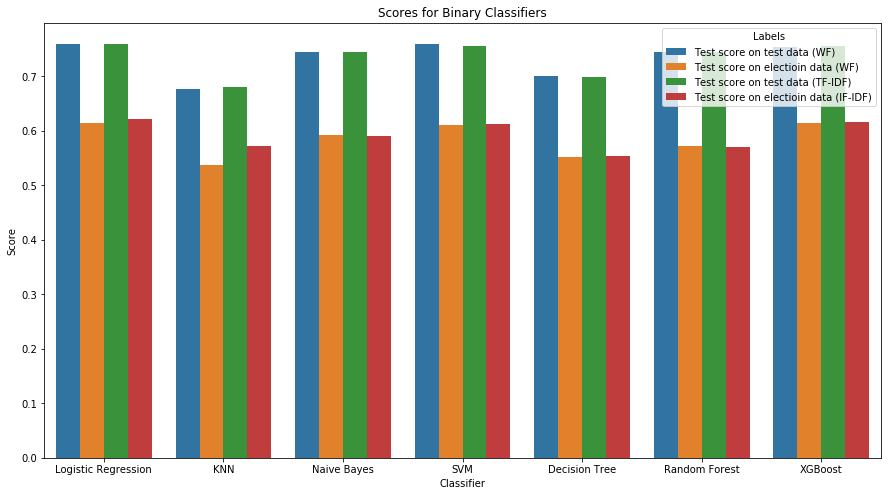

In [85]:
plt.subplots(figsize=(15,8))
sns.barplot(x=results_binary['Classifier'], y=results_binary['Score'], hue=results_binary['Labels'])
plt.title('Scores for Binary Classifiers')
plt.show()

- __Analysis:__
    - The two features (WF and TF-IDF) give the similar scores.
    
    - The scores of test set data are constantly higher than the election data with about 0.1. This means that the training data may not represent the election data well. 
    
    - The test scores of test set data is about 0.75, which is acceptable. But the scores of election data are only about 0.6, 10% higher than random guess (0.5), which is slightly lower. For election data, it is overfitted.
    
    - __The reason of overfitting__: There are tens of thousand words in the training data, most of which are not relevant to the _election data_, thus the words in _election data_ may not be well considered by the model. So for _election data_, the major error may come from the variance of the dataset.
    
- __The best model__:

    - From the figure above, the model with both high scores for both dataset is the __logistc regression__ model. Therefore, the following analysis will use the training results from logistc regression with the TF-IDF feature, which is slightly higher than its counterpart.

In [88]:
# sentiment prediction to the election outcome
c_elect_cleaned['parties'] = type_list
c_elect_cleaned['sentiment_pred'] = lr_yPredEle_tf
label_dict={0:'Negative_pred', 1: 'Positive_pred'}
c_elect_cleaned['sentiment_pred'] = c_elect_cleaned['sentiment_pred'].map(label_dictict)

In [92]:
c_elect_analysis = c_elect_cleaned[~(c_elect_cleaned['parties']== 'None')]

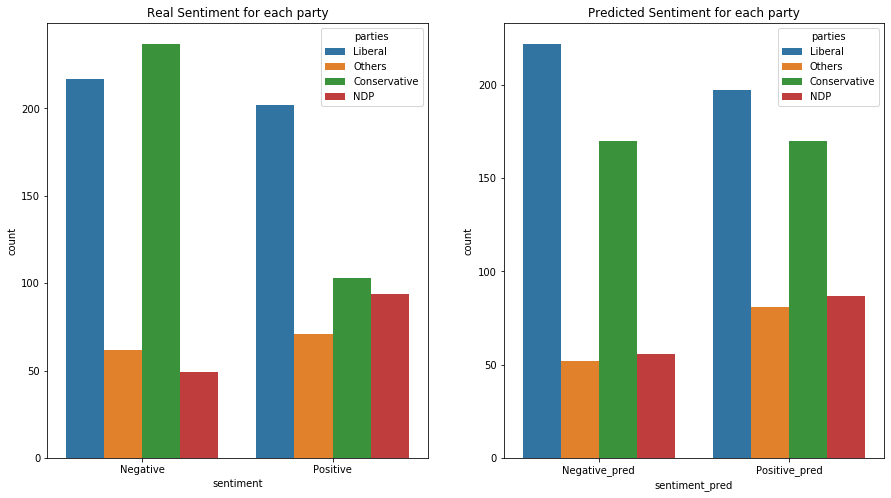

In [107]:
fig, ax = plt.subplots(1, 2, figsize=(15,8))
sns.countplot(x=c_elect_analysis['sentiment'], hue=c_elect_analysis['parties'], ax=ax[0])
sns.countplot(x=c_elect_analysis['sentiment_pred'], hue=c_elect_analysis['parties'], ax=ax[1])
ax[0].set_title('Real Sentiment for each party')
ax[1].set_title('Predicted Sentiment for each party')

plt.show()

- __Analysis__:
    1. For both figures, Liberal and Conservative are the dominant parts. 
    2. The real label reveals that Negative tweets are higher than Positive for the two parties. For NDP and other parties, Positive views are higher, but the overral populations are far less than the previous two.
    3. The prediction correctly predict the trend of other parties, NDP and Liberal, but inccorrectly predicted the Conservative. The Conservative has much more Negative labels, but the prediction results show the Negative and Positive are comparable. This may significantly influence the prediction of election results. Because for the real labels, Conservative has much more Negative tweets, and thus may lose the election, and Liberal is likely to win. But for the predicted labels, Conservative wins seems more reasonable.
    4. Given the performance score of the best model is still low (about 0.6), and it still estimates most of the trends, but lose on the key trends, so I believe NLP based analytics is useful to help parties know the population opinions. But the model should be well trained.
    5. The reason the model performs not well is as follow:
    - The training data is not representative, the detailed discussion is under the above figure.
    - The length of the training data is shorter, which means the training data is much simpler compared to election data.
    - Some of the models are too compuational, to I only selected one or two hyperparameters for tuning.
    If only select one way to improve the performance of the model, I would suggest to train with more selective data, like tweets related to elections from the last year, or other countries.

### 6.2 Multiclass Classification

- Performance of the model

In [139]:
multi_results = pd.DataFrame({
    'Classifiers': ['LogisticRegression with wf', 'Naive Bayes with wf', 'SVM with wf', 'LogisticRegression with tf-idf', 'Naive Bayes with tf-idf', 'SVM with tf-idf'],
    'Scores': [lr_ts_Nwf, nb_ts_Nwf, svm_ts_Nwf, lr_ts_Ntf, nb_ts_Ntf, svm_ts_Ntf]
})

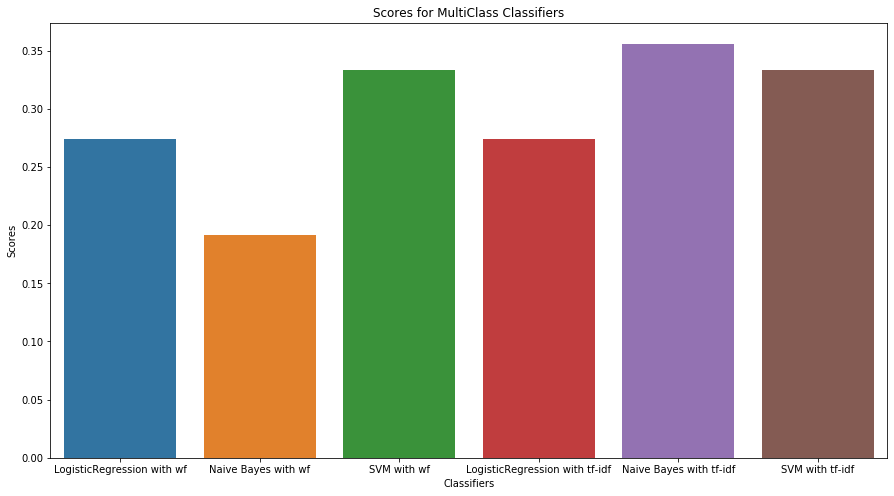

In [144]:
plt.subplots(figsize=(15,8))
sns.barplot(multi_results['Classifiers'], y=multi_results['Scores'])
plt.title('Scores for MultiClass Classifiers')
plt.show()

- Thus, Naive Bayes with TF-IDF features is the best model.

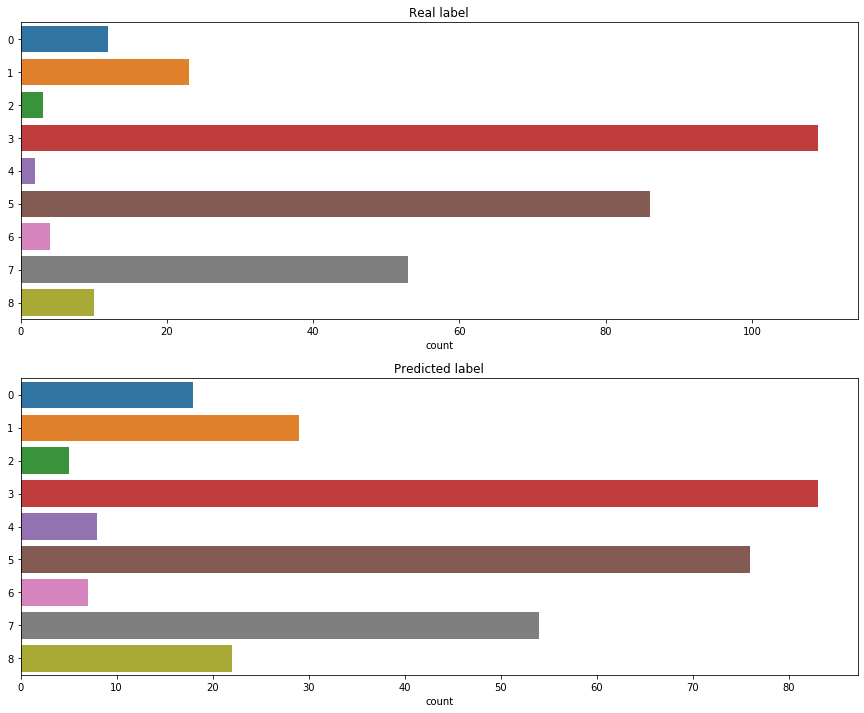

In [152]:
fig, ax = plt.subplots(2, 1, figsize=(15,12))
sns.countplot(y=y_test_Ntf, orient="v", ax=ax[0])
sns.countplot(y=nb_yPredEle_Ntf, orient="v", ax=ax[1])
ax[0].set_title('Real label')
ax[1].set_title('Predicted label')

plt.show()


- __Analysis__:
    - The predicted labels and real label distributions are the similar.
    - type 0 and type 8 are overfitted.
    - I guess the low performance (0.35) is due to the imbalanced labels.
    - One adivce is to use the balanced label as training data.